In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from matplotlib.dates import DateFormatter
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d

# Vehicle and environment parameters
m = 235  # Vehicle mass + driver
g = 9.81  # Gravitational constant in m/s^2
rho = 1.22  # Air density in kg/m^3
cd = 0.9  # Drag coefficient
A = 0.9323  # Front surface area in m^2
I = 0.764768  # Internal moment of inertia in kg*m^2
r_wheel = 0.35  # Wheel radius in meters
c_roll = 0.02  # Roll drag coefficient
c_rad = 0.01  # Radial drag coefficient
power_efficiency = 0.85
regenerative_efficiency = 0.50

# Upload your data File
data = pd.read_csv('Unit3_4.csv')

# Convert speed from km/h to m/s
data['Speed'] = data['Speed'] * 1000 / 3600

# Calculate delta_v
data['delta_v'] = data['Speed'].diff()

# Calculate delta_s (Covered Distance, since sampling is done at 1s)
data['delta_vk_1'] = data['delta_v'].shift(-1)

# Convert 'Time' to datetime
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S')

# Calculate delta_s = 0.5*delta_v + v[k-1]
data['delta_s'] = (0.5 * data['delta_v'] + data['delta_vk_1']).abs()

# Calculate kinetic energy
data['E_kin'] = 0.5 * m * (data['Speed'] ** 2)

# Calculate delta E_pot
data['E_pot'] = m * g * data['Altitude']

# Calculate delta E_rot drag
data['E_rot_drag'] = 0.5 * (I * (data['Speed'] ** 2))

# Calculate motorcycle energy
data['E_mot'] = data['E_kin'] + data['E_pot'] + data['E_rot_drag']

# Calculate delta E_air
data['E_air'] = 0.5 * rho * cd * A * (data['Speed'] ** 2) * data['delta_s'] * np.cos(data['Slope Angle (rad)'])

# Calculate delta E_roll
data['E_roll'] = m * g * c_roll * data['delta_s'] * np.cos(data['Slope Angle (rad)'])

# Calculate delta E_curve
data['E_curve'] = c_rad * m * (data['Speed'] ** 2) * data['Heading'].diff()

# Calculate total energy losses
data['E_loss'] = data['E_air'] + data['E_roll'] + data['E_curve']

# Shift E_mot values down by one row
data['E_mot_next'] = data['E_mot'].shift(1)

# Calculate the difference between the next E_mot value and the current E_mot value
data['E_mot_diff'] = data['E_mot_next'] - data['E_mot']

# Calculate total energy gain
data['E_gain'] = data['E_mot_diff'] - data['E_loss']

# Calculate total energy consumed by the movement of the Electric Vehicle
data['E_consumed'] = -data['E_gain']

# Convert total energy to kilowatts
data['Power_kw'] = data['E_consumed'] / 1000

# Power withdrawn from the battery
data['battery'] = data['Power_kw']
data.loc[data['battery'] < 0, 'battery'] = 0

data['P_battery'] = data['battery'] / power_efficiency

# Calculate power regenerated to the battery
data.loc[data['E_consumed'] < 0, 'P_regenerated'] = data['E_consumed'] * regenerative_efficiency / 1000

#_______________________________________________________________________________________________________________________________________________________

# Smooth the energy consumption data
data['E_gain_smoothed'] = gaussian_filter1d(data['E_consumed'], sigma=10)

# Calculate the smoothed power regenerated to the battery
data.loc[data['E_gain_smoothed'] < 0, 'P_regenerated_smoothed'] = data['E_gain_smoothed'] * regenerative_efficiency / 1000

# Identify and interpolate the missing values in P_regenerated
missing_indices = data['P_regenerated_smoothed'].isnull()
data['P_regenerated_smoothed'] = data['P_regenerated_smoothed'].interpolate(method='linear')
#---------------------------------------------------------------------------------------------------------------------------------
# Smooth the total energy profile using a Gaussian filter
smoothed_total_energy = gaussian_filter1d(data['Power_kw'], sigma=10)

# Power withdrawn from the battery
data['battery'] = smoothed_total_energy
data.loc[data['battery'] < 0, 'battery'] = 0

smoothed_power_battery = data['battery'] / power_efficiency

# Smooth the filled P_regenerated data using a Gaussian filter
smoothed_power_regenerated = data['P_regenerated_smoothed']
#__________________________________________________________________________________________________________________________________________________________






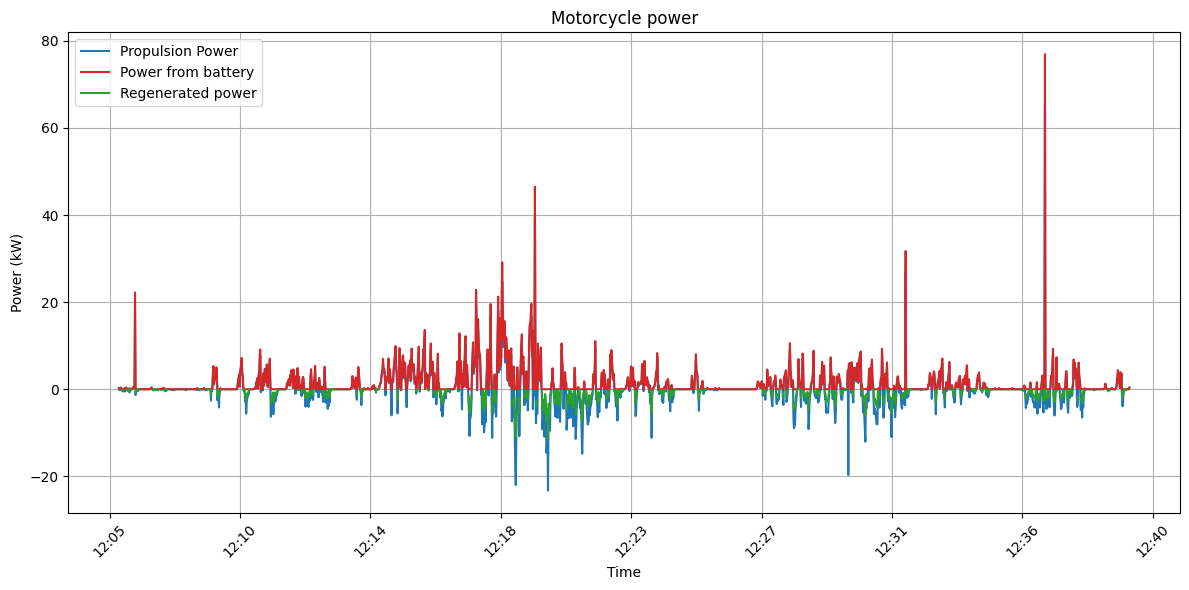

In [20]:
# Plot total energy profile
plt.figure(figsize=(12, 6))
plt.plot(data['Time'], data['Power_kw'], color='tab:blue', label='Propulsion Power')
plt.plot(data['Time'], data['P_battery'], color='tab:red', label='Power from battery')
plt.plot(data['Time'], data['P_regenerated'], color='tab:green', label='Regenerated power')
plt.xlabel('Time')
plt.ylabel('Power (kW)')
plt.title('Motorcycle power')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(DateFormatter("%H:%M"))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.legend()
plt.tight_layout()
plt.show()

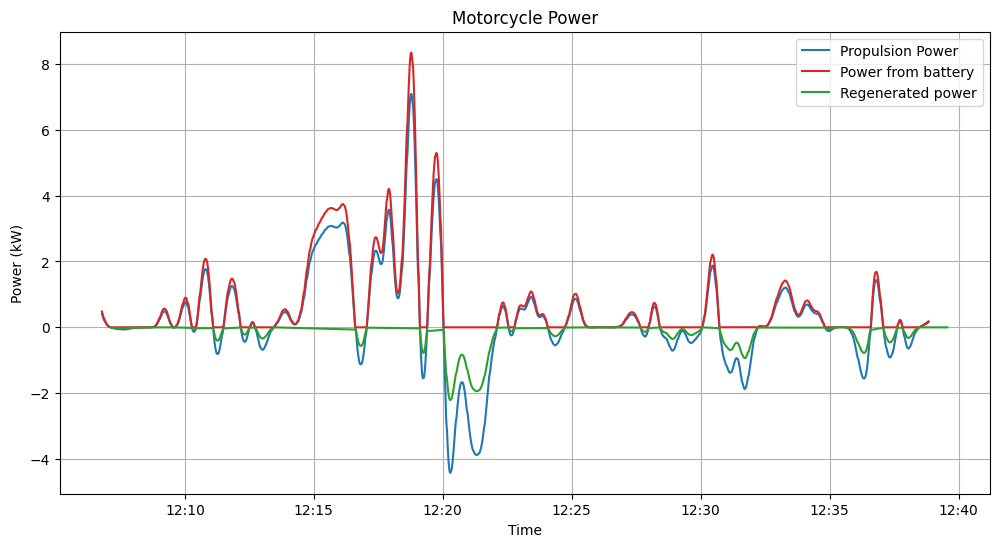

In [21]:
# Plot the smoothed total energy profile
plt.figure(figsize=(12, 6))
plt.plot(data['Time'], smoothed_total_energy, color='tab:blue', label='Propulsion Power')
plt.plot(data['Time'], smoothed_power_battery, color='tab:red', label='Power from battery')
plt.plot(data['Time'], smoothed_power_regenerated, color='tab:green', label='Regenerated power')
plt.xlabel('Time')
plt.ylabel('Power (kW)')
plt.title('Motorcycle Power')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(DateFormatter("%H:%M"))
plt.legend()
plt.show()

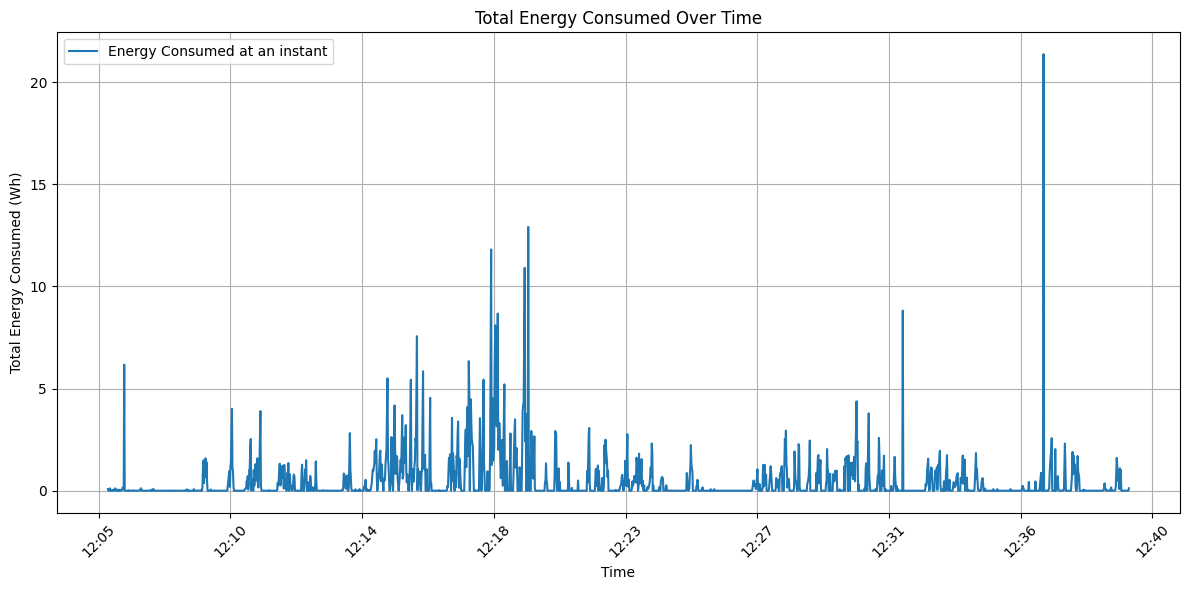

In [22]:
# Calculate the energy consumption in kWh at each time step
data['Energy Consumption (Wh)'] = data['P_battery'] * (data['Time'].diff().dt.total_seconds() / 3600)

# Calculate the total energy consumed over time
data['Total Energy Consumed (Wh)'] = data['Energy Consumption (Wh)'] * 1000

# Plot total energy consumed over time
plt.figure(figsize=(12, 6))
plt.plot(data['Time'], data['Total Energy Consumed (Wh)'], color='tab:blue', label='Energy Consumed at an instant')
plt.xlabel('Time')
plt.ylabel('Total Energy Consumed (Wh)')
plt.title('Total Energy Consumed Over Time')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(DateFormatter("%H:%M"))
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.legend()
plt.tight_layout()
plt.show()

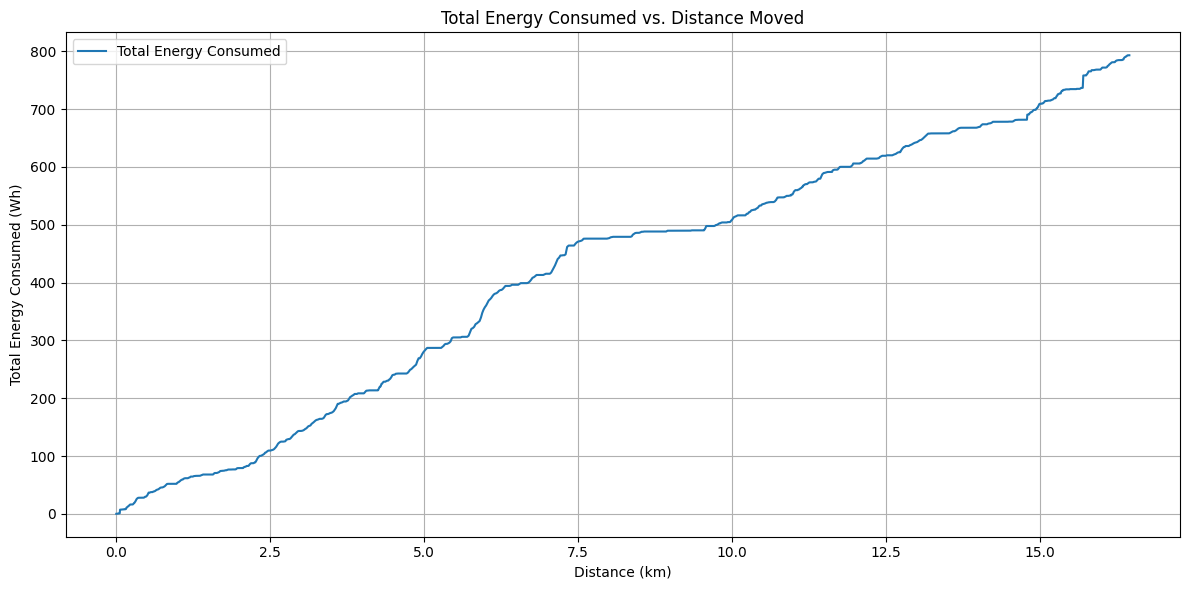

In [23]:
# Calculate the cumulative sum of energy consumed
data['Total Energy Consumed (Wh)'] = data['Total Energy Consumed (Wh)'].cumsum()

# Calculate cumulative distances
coordinates = list(zip(data['Latitude'], data['Longitude']))
distances = [0.0] + [geodesic(coordinates[i], coordinates[i + 1]).kilometers for i in range(len(coordinates) - 1)]
cumulative_distances = np.cumsum(distances)

# Plot total energy consumed over distance moved
plt.figure(figsize=(12, 6))
plt.plot(cumulative_distances, data['Total Energy Consumed (Wh)'], color='tab:blue', label='Total Energy Consumed')
plt.xlabel('Distance (km)')
plt.ylabel('Total Energy Consumed (Wh)')
plt.title('Total Energy Consumed vs. Distance Moved')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

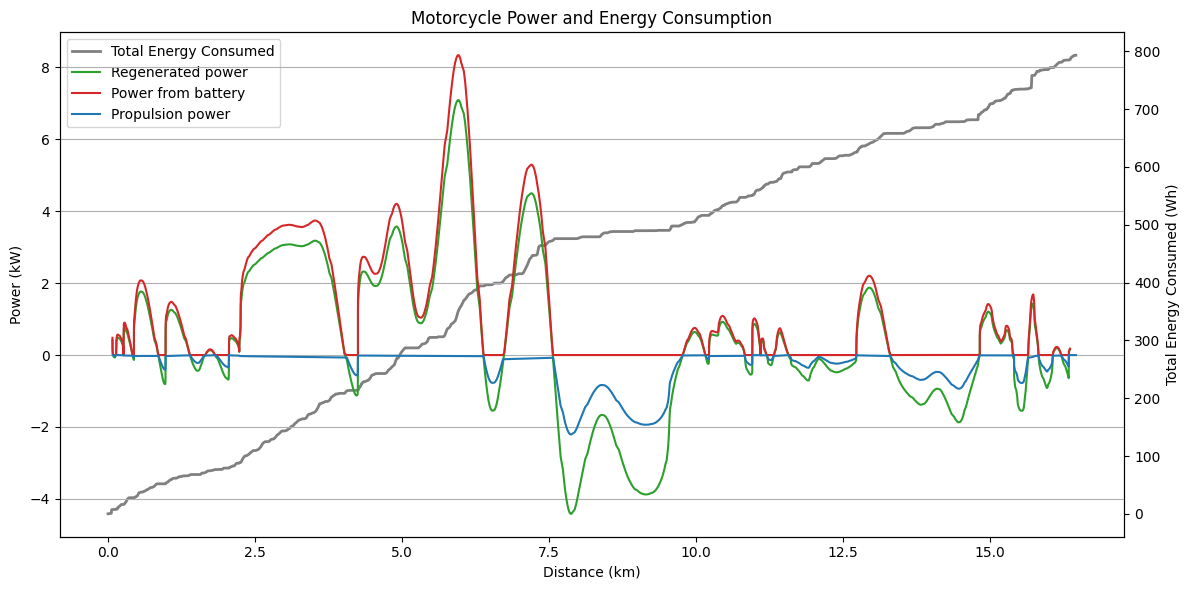

In [24]:
# Create figure and axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Create a second y-axis for power
ax2 = ax1.twinx()

# Plot total energy consumed over distance moved
ax1.plot(cumulative_distances, data['Total Energy Consumed (Wh)'], color='grey', label='Total Energy Consumed', linewidth=2)
ax1.set_xlabel('Distance (km)')
ax1.set_ylabel('Total Energy Consumed (Wh)', color='black')  # Changed ylabel to 'Power (kW)'
ax1.tick_params(axis='y', labelcolor='black')  # Changed labelcolor to 'black'
ax1.yaxis.set_label_position('right')  # Set position to right
ax1.yaxis.tick_right()  # Set ticks to right
ax1.set_title('Motorcycle Power and Energy Consumption')

# Plot power from battery and regenerated power
ax2.plot(cumulative_distances, smoothed_total_energy, color='tab:green', label='Regenerated power')
ax2.plot(cumulative_distances, smoothed_power_battery, color='tab:red', label='Power from battery')
ax2.plot(cumulative_distances, smoothed_power_regenerated, color='tab:blue', label='Propulsion power')
ax2.set_ylabel('Power (kW)', color='black')  # Changed ylabel to 'Total Energy Consumed (Wh)'
ax2.tick_params(axis='y', labelcolor='black')  # Changed labelcolor to 'grey'
ax2.yaxis.set_label_position('left')  # Set position to left
ax2.yaxis.tick_left()  # Set ticks to left

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper left')

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()
